#**PROBLEM STATEMENT**

ingin memprediksi orang-orang yang berpotensi telat bayar kartu kredit finanku untuk dapat menentukan strategi yag sesuai untuk menghadapinya.
---



#**Objective**

Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit (Accuracy dan Recall > 60%).

#**Variable**

Customer ID: unique ID customer.

Branch: lokasi cabang nasabah terdaftar.

City: lokasi kota nasabah terdaftar.

Age: umur nasabah pada periode observasi.

Avg. Annual Income: rata-rata penghasilan nasabah dalam satu tahun.

Balance (Q1-Q4): saldo mengendap yang dimiliki nasabah di akhir kuartal.

Num of Product (Q1-Q4): jumlah kepemilikan produk nasabah yang dimiliki di akhir kuartal.

HasCrCard (Q1-Q4): status kepemilikan produk kartu kredit nasabah di akhir kuartal.

Active Member (Q1-Q4): status keaktifan nasabah.

Unpaid tagging: status nasabah gagal bayar.

#**Experiment**

**Periode tinjauan:**

Nasabah di-review selama satu tahun terakhir.

Nasabah di-review selama 6 bulan terakhir.

**Penyesuaian variabel:**

Balance dilihat dari rata-rata selama horizon waktu dan dilihat perubahan pada akhir tinjauan dan awal tinjauan.

Melihat kepemilikan jumlah produk dari rata-rata, maksimum, dan minimum pada periode tinjauan.

Status keaktifan nasabah dilihat dalam bentuk bulan.

#**Import Package**

In [ ]:
!pip install jcopml #jika tidak ada modul/package jcopml

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from jcopml.feature_importance import mean_score_decrease

#**Data for Prediction**

In [ ]:
path_1 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path_2 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

##**Dataframe for each experiment**

In [ ]:
df1 = pd.read_csv(path_1) #untuk eksperimen 1
df1.head()

In [ ]:
df2 = pd.read_csv(path_1) #untuk eksperimen 2
df2.head()

#**Data Understanding**

##**Location based customer disribution**



1.   Sebaran Keseluruhan
2.   Sebaran nasabah gagal bayar



In [ ]:
data1 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan kota
                       df_all.groupby(by=['City'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #Mengurutkan data
                       .sort_values(ascending=False)\
                      #reset nama header
                       .reset_index(name='Distribution by City'))
data1

**Sebaran nasabah gagal bayar**

In [ ]:
data2 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan kota
                       df_all[df_all['Unpaid Tagging']==1].groupby(by=['City'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #Mengurutkan data
                       .sort_values(ascending=False)\
                      #reset nama header
                       .reset_index(name='Distribution by City'))
data2

##**Customer Distribution by Age**

**Data keseluruhan**

In [ ]:
data3 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan usia                      df_all.groupby(by=['Age'])['Customer ID']\
                       df_all.groupby(by=['Age'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #reset nama header
                       .reset_index(name='Distribution by Age'))
data3.sort_values(\
                  by=['Age'], \
                  ascending=True, \
                  inplace=True)
data3.plot(x='Age',
          y=['Distribution by Age'],
          kind='bar',
          grid=True,
          xlabel='Age',
          ylabel='# People',
          figsize=(12,7),
          rot=0,
          title='Cust. Distribution by Age',
          table=False,
          secondary_y = False)

**Data gagal bayar**

In [ ]:
data4 = pd.DataFrame(\
                      #Mengelompokkan berdasarkan usia
                       df_all[df_all['Unpaid Tagging']==1].groupby(by=['Age'])['Customer ID']\
                      #Diagegatkan dengan menghitung jumlahnya (count)
                       .count()\
                      #reset nama header
                       .reset_index(name='Distribution by Age'))
data4.sort_values(\
                  by=['Age'], \
                  ascending=True, \
                  inplace=True)
data4.plot(x='Age',
          y=['Distribution by Age'],
          kind='bar',
          grid=True,
          xlabel='Age',
          ylabel='# People',
          figsize=(12,7),
          rot=0,
          title='Unpaid Cust. Distribution by Age',
          table=False,
          secondary_y = False)

##**Average annual balance**

In [ ]:
df_checkbalance = df_all
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1'] + df_checkbalance['Balance Q2'] + df_checkbalance['Balance Q3'] + df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1'] + df_checkbalance['Balance Q2'] + df_checkbalance['Balance Q3'] + df_checkbalance['Balance Q4'])/4

data5 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Total Balance']\
                      .mean()\
                      .reset_index(name='Avg Annual Balance'))
data5

from the data above, we r getting information that unpaid customer punya lebih banyak balance daripada paid customer

In [ ]:
data6 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Avg Balance']\
                      .mean()\
                      .reset_index(name='Avg Quarterly Balance'))
data6

##**Average product owned**

In [ ]:
df_checkbalance['Avg Product'] = (df_checkbalance['NumOfProducts Q1'] +
                                   df_checkbalance['NumOfProducts Q2'] +
                                   df_checkbalance['NumOfProducts Q3'] +
                                   df_checkbalance['NumOfProducts Q4'])/4
data7 = pd.DataFrame(\
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Avg Product']\
                      .mean()\
                      .reset_index(name='Avg Product Owned'))
data7

In [ ]:
df_all = df_all.drop(columns=['Total Balance', 'Avg Balance', 'Avg Product'])

#**Data Preparation**

##**Duplicated and missing data handling**

In [ ]:
df_all.duplicated().sum()

In [ ]:
df_all.isnull().sum()

##**Relevant variable adding**




1.   Eksperimen 1: rata-rata saldo nasabah dalam 1 tahun terakhir dan perubahan saldo di Q4 terhadap Q1.

2.   Eksperimen 2: rata-rata saldo nasabah dalam 6 bulan terakhir dan perubahan saldo di Q4 terhadap Q1.




###**Mean balance**

####**Eksperimen 1**

In [ ]:
df1['Mean Balance'] = (df1['Balance Q1'] + df1['Balance Q2'] + df1['Balance Q3'] + df1['Balance Q4'])/4
df1['Delta Balance'] = df1['Balance Q4'] - df1['Balance Q1']
df1.head()

####**Eksperimen 2**

In [ ]:
df2['Mean Balance']= (df2['Balance Q3'] + df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4'] - df2['Balance Q2']
df2.head()

###**Active status**

####**Eksperimen 1**

In [ ]:
df1['Active Months'] = (df1['ActiveMember Q1'] + df1['ActiveMember Q2'] + df1['ActiveMember Q3'] + df1['ActiveMember Q4'])*3
df1.head()

####**Eksperimen 2**

In [ ]:
df2['Active Months'] = (df2['ActiveMember Q3'] + df2['ActiveMember Q4'])*3
df2.head()

###**Product Handling**

####**Eksperimen 1**

In [122]:
df1['Diff PH'] = df1['NumOfProducts Q4'] - df1['NumOfProducts Q1']
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


####**Eksperimen 2**

In [123]:
df2['Diff PH'] = df2['NumOfProducts Q4'] - df2['NumOfProducts Q2']
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,1,431190.68,2,1,1,0,555048.18,431190.68,6,0


###**Vintage Cr**

lama kepemilikan kartu dalam periode observasi

In [124]:
def assign_cr1(df):
  if df['HasCrCard Q1'] == 1:
    return 12
  elif df['HasCrCard Q2'] == 1:
    return 9
  elif df['HasCrCard Q3'] == 1:
    return 6
  else:
    return 3
  return np.nan

####**Eksperimen 1**

In [125]:
df1['Vintage_CR'] = df1.apply(assign_cr1, axis=1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


####**Eksperimen 2**

In [126]:
df2['Vintage_CR'] = df2.apply(assign_cr1, axis=1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,1187036.18,1,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,1351820.24,2,1,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0.00,2,1,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,431190.68,2,1,1,0,555048.18,431190.68,6,0,12


##**Variable removing**

Status kepemilikan sudah digantikan dengan lama kepemilikan kartu kredit.

HasCrCard ->> vintage_cr

In [127]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])
df2 = df2.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])

Balance Per Quarter sudah digantikan dengan rata-rata saldo dalam periode observasi dan selisih saldo di awal dan akhir periode observasi.

balance ->> mean_balance

In [128]:
df1 = df1.drop(columns = ['Balance Q1','Balance Q2','Balance Q3','Balance Q4'])
df2 = df2.drop(columns = ['Balance Q1','Balance Q2','Balance Q3','Balance Q4'])

NumOfProducts ->> diff_PH

In [129]:
df1 = df1.drop(columns = ['NumOfProducts Q1','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])
df2 = df2.drop(columns = ['NumOfProducts Q1','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])

activeMember ->> active month

In [130]:
df1 = df1.drop(columns = ['ActiveMember Q1','ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2 = df2.drop(columns = ['ActiveMember Q1','ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

##**Data Transformation**

###**Predictor Variable Separating**

In [131]:
predictor1 = df1[df1.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [132]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [133]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,3,29,33000000,1001,Jakarta,1187036.18,0,593518.09,12
1,0,68,17000000,1005,Jakarta,0.00,0,0.00,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,675910.12,12
3,0,42,19000000,1008,Jakarta,0.00,0,0.00,12
4,6,43,29000000,1009,Jakarta,431190.68,0,555048.18,12


###**Data Category Encoding**

Kategori variabel:

1. Branch Code

2. City

Untuk branch code perlu diubah menjadi string agar dianggap sebagai data kategori.

In [134]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


<ipython-input-134-b9748522fe9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
<ipython-input-134-b9748522fe9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


In [135]:
predictor1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [136]:
predictor2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


 ubah tipe data kategori menjadi variable indikator/dummy.

In [137]:
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)

In [138]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,3,68,17000000,0.00,0,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,337955.060,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,3,42,19000000,0.00,0,0.000,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,277524.090,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [139]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,...,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,593518.09,12,True,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.00,0,0.00,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,675910.12,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.00,0,0.00,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,555048.18,12,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [140]:
predname = predictor1.columns
predname_num = predictor1.columns[0:7] #mengambil kolom yang numerik
predname_cat = predictor1.columns[7:31] #mengambil kolom yang sifatnya kategorik

In [141]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat]

##**Numeric Data Standardization**

###**Eksperimen 1**

In [142]:
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()
X1_num = pd.DataFrame(pt.fit_transform(X1_num))

X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [143]:
#ganti nama kolom

X1_num.columns = predname_num
X1_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


###**Eksperimen 2**

In [144]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [145]:
#ganti nama kolom

X2_num.columns = predname_num
X2_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


##**Grouping predictor dataset**

gabungin data predictor

In [146]:
X1 = pd.concat([X1_cat, X1_num], axis = 1)
X2 = pd.concat([X2_cat, X2_num], axis = 1)
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [147]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [148]:
#variabel dependen
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

##**Preparing Dataset for Validation**

###**Import Data**

In [149]:
df1_val = pd.read_csv(path_2) #untuk eksperimen 1
df2_val = pd.read_csv(path_2) #untuk eksperimen 2



*   Penambahan variabel relevan



In [150]:
df1_val['Mean Balance'] = (df1_val['Balance Q2'] + df1_val['Balance Q3'] + df1_val['Balance Q4'] + df1_val['Balance Q5'])/4
df1_val['Delta Balance'] = df1_val['Balance Q4'] - df1_val['Balance Q5']

df2_val['Mean Balance']= (df2_val['Balance Q5'] + df2_val['Balance Q2'])/2
df2_val['Delta Balance'] = df2_val['Balance Q5'] - df2_val['Balance Q3']



*   Status keaktifan



In [151]:
df1_val['Active Months'] = (df1_val['Balance Q3'] + df1_val['Balance Q2'] + df1_val['Balance Q5'] + df1_val['Balance Q4'])*3
df2_val['Active Months']= (df2_val['Balance Q4'] + df2_val['Balance Q5'])*3



*  Product Handling



In [152]:
df1_val['Diff PH'] = df1_val['Balance Q5'] - df1_val['Balance Q2']
df2_val['Diff PH'] = df2_val['Balance Q5'] - df2_val['Balance Q3']

*  Vintage CR

In [153]:
def assign_cr2(df):
  if df['HasCrCard Q2'] == 1:
    return 12
  elif df['HasCrCard Q3'] == 1:
    return 9
  elif df['HasCrCard Q4'] == 1:
    return 6
  else:
    return 3
  return np.nan

In [154]:
df1_val['Vintage_CR'] = df1_val.apply(assign_cr2, axis=1)
df2_val['Vintage_CR'] = df2_val.apply(assign_cr2, axis=1)

*  Variable removing

In [155]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4', 'Balance Q5','Balance Q2','Balance Q3','Balance Q4', 'NumOfProducts Q5','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4', 'ActiveMember Q5','ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2_val = df2_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4', 'Balance Q5','Balance Q2','Balance Q3','Balance Q4', 'NumOfProducts Q5','NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4', 'ActiveMember Q5','ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])



*  Predictor variable

In [156]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]

predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

<ipython-input-156-5603a55ecf71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
<ipython-input-156-5603a55ecf71>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)


In [157]:
predname = predictor1_val.columns
predname_num = predictor1_val.columns[0:7] #mengambil kolom yang numerik
predname_cat = predictor1_val.columns[7:31] #mengambil kolom yang sifatnya kategorik

In [158]:
X1_num_val = predictor1_val[predname_num]
X2_num_val = predictor2_val[predname_num]

X1_cat_val = predictor1_val[predname_cat]
X2_cat_val = predictor2_val[predname_cat]

In [159]:
X1_num_val = pd.DataFrame(pt.fit_transform(X1_num_val))
X2_num_val = pd.DataFrame(pt.fit_transform(X2_num_val))

X1_val = pd.concat([X1_cat, X1_num], axis=1)
X2_val = pd.concat([X2_cat, X2_num], axis=1)

In [160]:
#variabel dependen
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']

##**Correlation Cheking**

In [161]:
corrtest1 = X1.corr().abs() #tanpa melihat arah korelasinya apakah bernilai positif atau negatif, hanya melihat nilai korelasi absolutnya
corrtest2 = X2.corr().abs()

In [162]:
corrtest1

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,...,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,...,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,...,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,...,0.094442,0.281983,0.162551,0.006704,0.004534,0.007488,0.000112,0.017499,0.004003,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,...,0.095672,0.285654,0.164668,0.010148,0.011408,0.024003,0.002511,0.018648,0.006408,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,...,0.096403,0.287836,0.165926,0.000426,0.005992,0.000678,0.003350,0.006413,0.001808,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,...,0.098089,0.292872,0.168829,0.002480,0.002933,0.012510,0.001391,0.012129,0.005874,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,...,0.409857,0.137270,0.236432,0.001055,0.011252,0.016018,0.025531,0.004062,0.005530,0.020666


In [163]:
corrtest2

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,...,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,...,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,...,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,...,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,...,0.094442,0.281983,0.162551,0.002050,0.004534,0.007488,0.007557,0.002061,0.004017,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,...,0.095672,0.285654,0.164668,0.013401,0.011408,0.024003,0.002299,0.018009,0.006425,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,...,0.096403,0.287836,0.165926,0.005226,0.005992,0.000678,0.009595,0.012922,0.001792,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,...,0.098089,0.292872,0.168829,0.002926,0.002933,0.012510,0.002003,0.022414,0.005889,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,...,0.409857,0.137270,0.236432,0.002436,0.011252,0.016018,0.021118,0.012993,0.005449,0.020666


In [164]:
#Membuang nilai redundan pada matriks
upper1 = corrtest1.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))
upper2 = corrtest2.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

#Mencari nilai yang berkorelasi di atas 0.7
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.7)]
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

#menghapus kolom yang korelasinya >0.7
X1 = X1.drop(to_drop1, axis=1)
X2 = X2.drop(to_drop2, axis=1)


In [165]:

X1_val = X1_val.drop(to_drop1, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)

In [166]:
X1_val

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,...,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,...,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,...,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,...,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,...,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,False,False,False,False,False,False,False,False,False,False,...,False,False,True,0.742887,-0.901678,-0.764885,-0.676360,-0.531491,-0.414767,0.296502
7557,False,False,False,False,False,False,False,False,False,False,...,False,False,True,-1.891303,0.658654,-0.596822,-0.319523,-0.531491,2.063446,0.296502
7558,False,False,False,False,False,False,False,False,False,False,...,False,False,True,-1.891303,0.162185,-0.596822,-0.319523,-0.531491,-0.953281,0.296502
7559,False,False,False,False,False,False,False,False,False,False,...,False,False,True,1.620951,1.651592,-0.428759,-0.348307,-0.531491,-0.275996,0.296502


##**Train test data splitting**

In [167]:
y1.value_counts()
y2.value_counts()

,count
Unpaid Tagging,
0,5542
1,2019


In [168]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=30)

#**Modelling**

3 algoritma:

1. Logistic Regression
2. Gradient Boosting
3. Random Forest

##**Logistic Regression**

In [169]:
penalty = ['l2'] # Changed from ['12'] to ['l1', 'l2'] to provide valid penalty options
tol = [0.001, 0.0001, 0.00001]
C = [100.0, 10.0, 1.00, 0.1, 0.001]
fit_intercept = [True, False]
intercept_scaling = [1.0, 0.75, 0.5, 0.25]
class_weight = ['balanced', None]
solver = ['newton-cg', 'sag', 'lbfgs', 'saga']
max_iter = [14000]
param_distribution = dict(penalty=penalty, tol=tol, fit_intercept=fit_intercept,
                           intercept_scaling=intercept_scaling, class_weight=class_weight,
                            solver=solver, max_iter = max_iter)

In [170]:
from sklearn.model_selection import GridSearchCV

###**Eksperimen 1**

In [171]:
import time
#cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid=param_distribution,
        scoring = 'recall', cv=5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X1_train, y1_train)
#Summarize results
print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))
print('Execution time: ' + str((time.time() - start_time)) + ' s')

Best: 0.415440 using {'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 1.0, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.001}
Execution time: 66.28173780441284 s


###**Eksperimen 2**

In [ ]:
import time
#cross validation
logreg = LogisticRegression()
grid2 = GridSearchCV(estimator=logreg, param_grid=param_distribution,
        scoring = 'recall', cv=5, n_jobs=-1)

start_time = time.time()
grid_result = grid2.fit(X2_train, y2_train)
#Summarize results
print('Best: %f using %s' %(grid_result.best_score_, grid_result.best_params_))
print('Execution time: ' + str((time.time() - start_time)) + ' s')

##**Gradient Boosting**

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
!pip install --upgrade xgboost

In [ ]:
gbparameter = {'max_depth':[5,10,15], 'gamma':[0.0, 0.1, 0.2, 0.3],
                'n_estimators':[25,50,75,100], 'learning_rate':[0.05, 0.1, 0.2, 0.3],
                'scale_pos_weight':[1,3]}
score = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score),
         'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

###**Eksperimen 1**

In [ ]:
GB_Grid1 = GridSearchCV(XGBClassifier(), gbparameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [ ]:
start_time = time.time()
GB_result = GB_Grid1.fit(X1_train, y1_train)

#Summarize result
print('Best: %f using %s' % (GB_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() + start_time)) + 's')

###**Eksperimen 2**

In [ ]:
GB_Grid2 = GridSearchCV(XGBClassifier(), gbparameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [ ]:

start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train, y2_train)

#Summarize result
print('Best: %f using %s' % (GB2_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() + start_time)) + 's')

##**Random Forest**

parameter dalam algoritma Random Forest:

1. Max_depth: jumlah maksimal pemecahan cabang atau level dalam satu pohon. Semakin besar nilai max_depth yang ditetapkan, model akan semakin presisi dalam menggolongkan data ke suatu kelas. Akan tetapi, semakin besar nilai max_depth juga akan membuat model overfitting.
2. Max_features: jumlah maksimal fitur yang dipertimbangkan ketika melakukan pemecahan cabang (splitting node). Sama halnya dengan max_depth, semakin banyak jumlah fitur yang dipertimbangkan dalam pemecahan cabang, akan semakin detail hasil yang didapatkan tetapi juga akan membuat model overfitting terhadap data training-nya.
3. N_estimator: jumlah pohon yang akan dibangun. Semakin banyak pohon, tingkat akurasi yang didapatkan menjadi lebih baik mengingat Random Forest menggunakan konsep mahority vote dalam melakukan klasifikasi. Akan tetapi, semakin banyakk pohon yang dibangung, waktu komputasi yang dibutuhkan juga akan semakin tinggi.
4. Min_sample_split: jumlah sampel data minimal pada sebuah internal node. Nilai yang besar dapat membuat model yang dibangun lebih konservatif. Akan tetapi, jika terlalu besar dapat menyebabkan model yang dibangun underfitting.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
parameter = {'max_depth': [5,10,15,20], 'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [25,50,75,100,125], 'min_samples_split': [2,3,5,7]}
score = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score),
          'recall':make_scorer(recall_score), 'f1': make_scorer(f1_score)}

###**Eksperimen 1**

In [ ]:
RF_Grid = GridSearchCV(RandomForestClassifier(), parameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [81]:

start_time = time.time()
RF_result = RF_Grid.fit(X1_train, y1_train)
#Summarize result
print('Best: %f using %s' % (RF_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() + start_time)) + 's')

Best: 0.322021 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 3476766486.6632633s


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


###**Eksperimen 2**

In [82]:
RF_Grid2 = GridSearchCV(RandomForestClassifier(), parameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [83]:

start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train, y2_train)
#Summarize result
print('Best: %f using %s' % (RF_result2.best_score_, RF_result2.best_params_))
print('Execution time: ' + str((time.time() + start_time)) + 's')

Best: 0.318487 using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 3476767308.1810236s


#**Evaluation**

##**Logistic Regression**

###**Eksperimen 1**

In [84]:
y1_pred = grid.predict(X1_test)
from sklearn import metrics

In [85]:

print('Accuracy:', metrics.accuracy_score(y1_test, y1_pred))
print('Recall:', metrics.recall_score(y1_test, y1_pred))
metrics.completeness_score

Accuracy: 0.7774349933891582
Recall: 0.43564356435643564


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [86]:
y1_pred_val = grid.predict(X1_val)
print('Accuracy:', metrics.accuracy_score(y1_val, y1_pred_val))
print('Recall:', metrics.recall_score(y1_val, y1_pred_val))
metrics.completeness_score

Accuracy: 0.6386721333156989
Recall: 0.26245847176079734


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

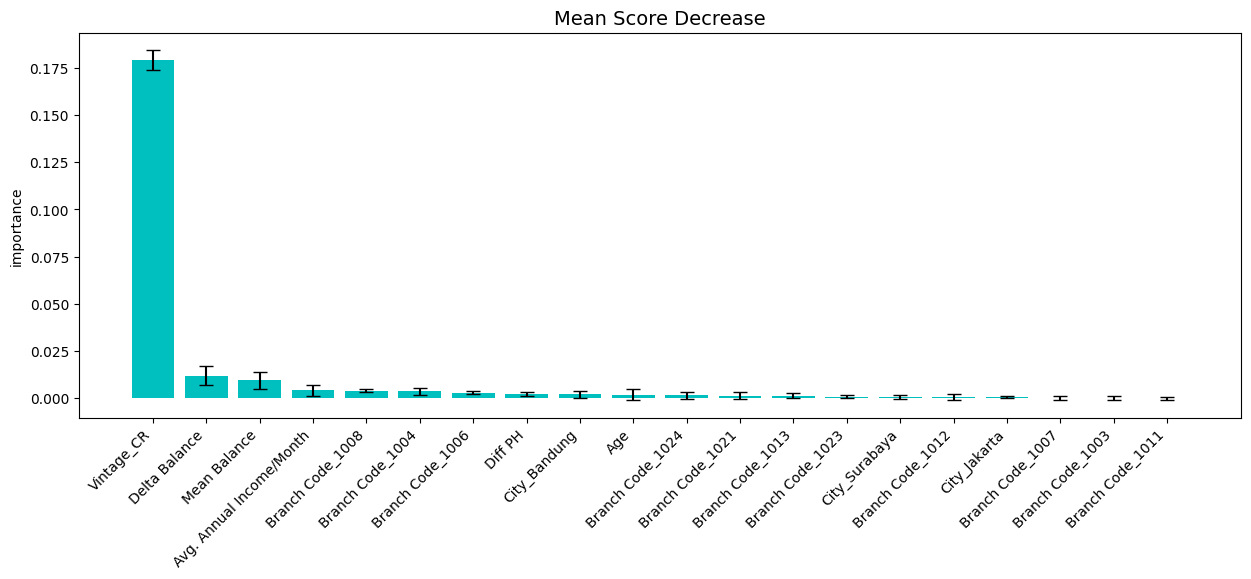

In [87]:
from jcopml.feature_importance import mean_score_decrease
df_imp1 = mean_score_decrease(X1_train, y1_train, grid, plot=True, topk=20)

###**Eksperimen 2**

In [88]:
y2_pred = grid.predict(X2_test)
print('Accuracy:', metrics.accuracy_score(y2_test, y2_pred))
print('Recall:', metrics.recall_score(y2_test, y2_pred))
metrics.completeness_score

Accuracy: 0.7637725870427501
Recall: 0.41254125412541254


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [89]:
y2_pred_val = grid.predict(X2_val)
print('Accuracy:', metrics.accuracy_score(y2_val, y2_pred_val))
print('Recall:', metrics.recall_score(y2_val, y2_pred_val))
metrics.completeness_score

Accuracy: 0.6365560111096416
Recall: 0.25987449243263194


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

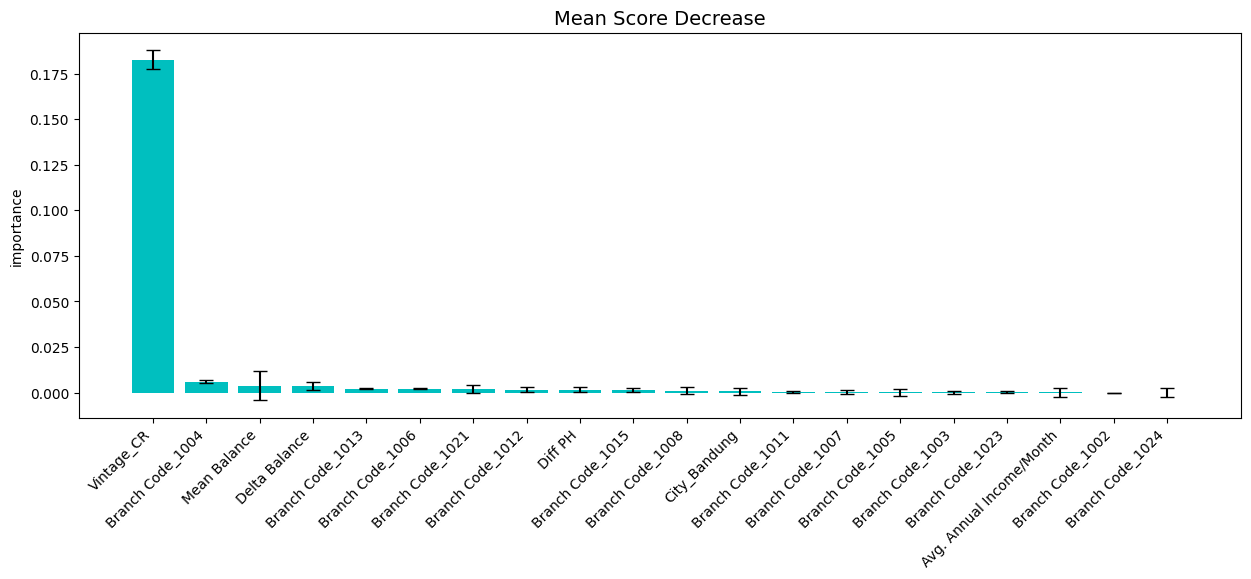

In [90]:
df_imp2 = mean_score_decrease(X2_train, y2_train, grid, plot=True, topk=20)

##**Gradient Boosting**

###**Eksperimen 1**

In [91]:
y11_pred = GB_Grid1.predict(X1_test)

In [92]:

print('Accuracy:', metrics.accuracy_score(y1_test, y11_pred))
print('Recall:', metrics.recall_score(y1_test, y11_pred))
metrics.completeness_score

Accuracy: 0.6862053768179814
Recall: 0.6056105610561056


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [93]:
y11_pred_val = GB_Grid1.predict(X1_val)
print('Accuracy:', metrics.accuracy_score(y1_val, y11_pred_val))
print('Recall:', metrics.recall_score(y1_val, y11_pred_val))
metrics.completeness_score

Accuracy: 0.5933077635233435
Recall: 0.4485049833887043


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

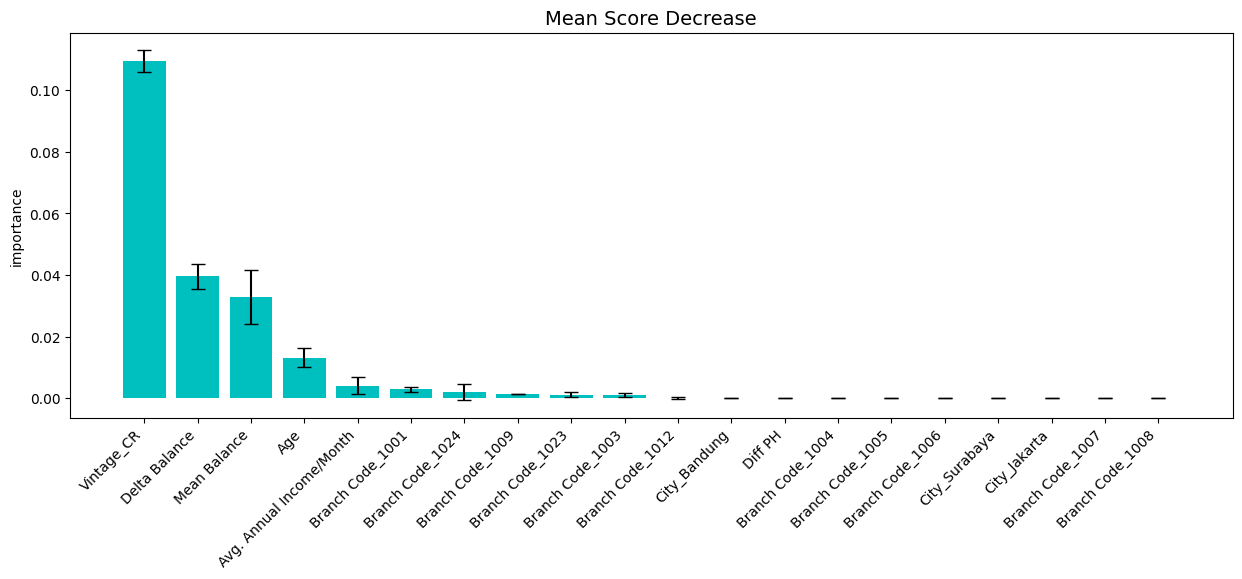

In [94]:
df_imp3 = mean_score_decrease(X2_train, y2_train, GB_Grid1, plot=True, topk=20)

###**Eksperimen 2**

In [95]:
y22_pred = GB_Grid2.predict(X2_test)
print('Accuracy:', metrics.accuracy_score(y2_test, y22_pred))
print('Recall:', metrics.recall_score(y2_test, y22_pred))
metrics.completeness_score

Accuracy: 0.7192595857205818
Recall: 0.5066006600660066


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [96]:
y22_pred_val = GB_Grid2.predict(X2_val)
print('Accuracy:', metrics.accuracy_score(y2_val, y22_pred_val))
print('Recall:', metrics.recall_score(y2_val, y22_pred_val))
metrics.completeness_score

Accuracy: 0.6306044174051052
Recall: 0.38870431893687707


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

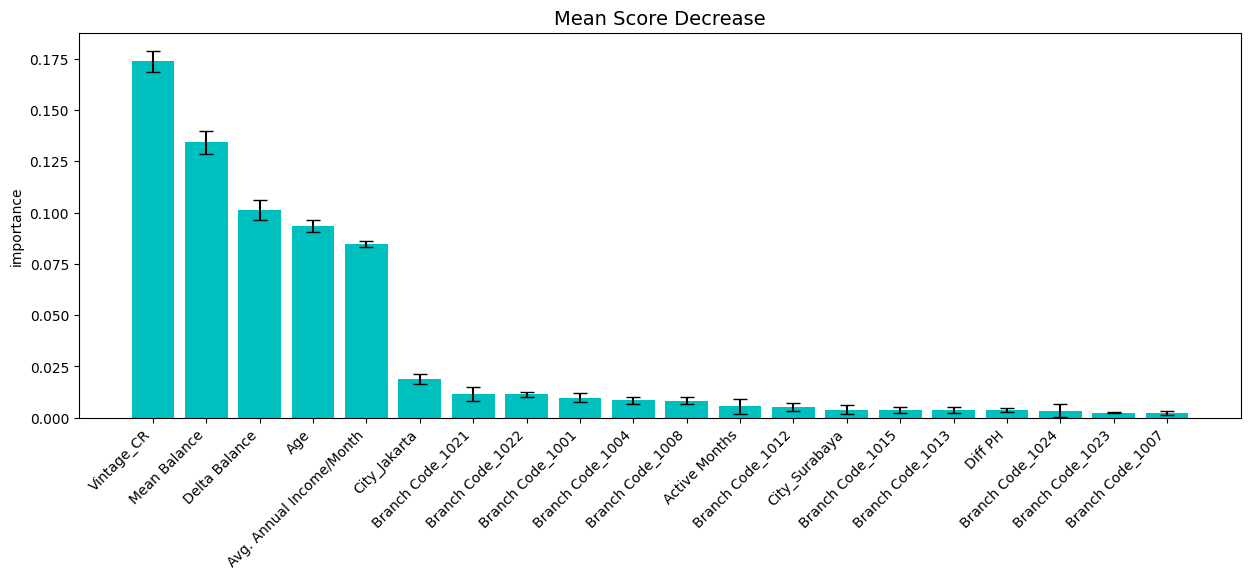

In [97]:
df_imp4 = mean_score_decrease(X2_train, y2_train, GB_Grid2, plot=True, topk=20)

##**Random Forest**

###**Eksperimen 1**

In [98]:
y12_pred =RF_Grid.predict(X1_test)
print('Accuracy:', metrics.accuracy_score(y1_test, y12_pred))
print('Recall:', metrics.recall_score(y1_test, y12_pred))
metrics.completeness_score

Accuracy: 0.8135742617893346
Recall: 0.33993399339933994


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [99]:
y12_pred_val =RF_Grid.predict(X1_val)
print('Accuracy:', metrics.accuracy_score(y1_val, y12_pred_val))
print('Recall:', metrics.recall_score(y1_val, y12_pred_val))
metrics.completeness_score

Accuracy: 0.7026848300489353
Recall: 0.3252122554448136


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

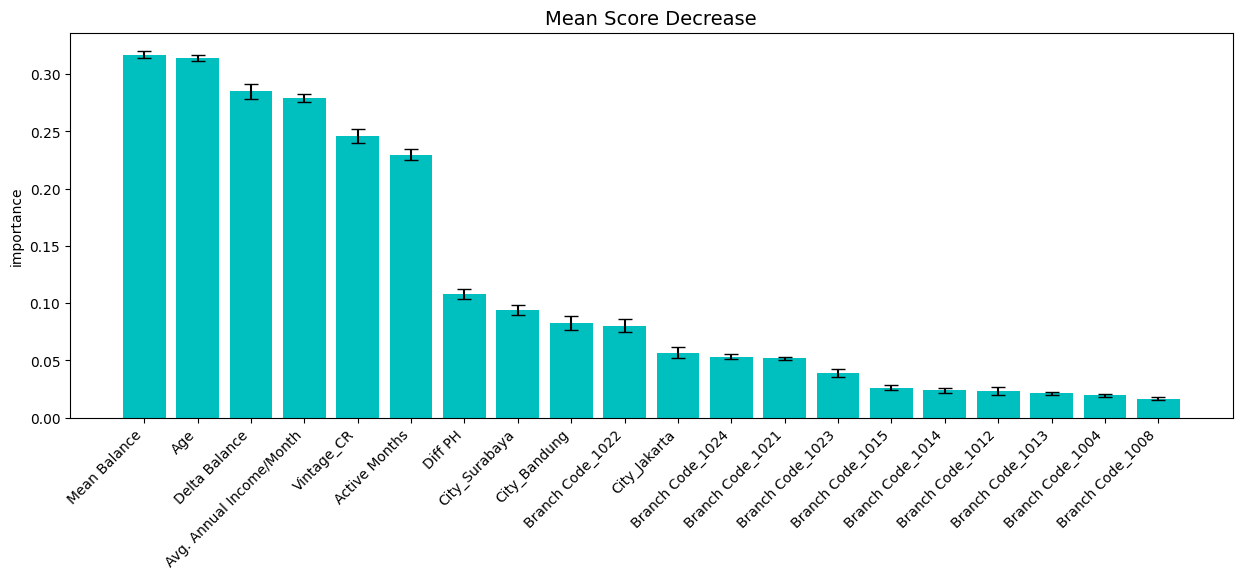

In [100]:
df_imp5 = mean_score_decrease(X1_train, y1_train, RF_Grid, plot=True, topk=20)

###**Eksperimen 2**

In [101]:
y21_pred =RF_Grid2.predict(X2_test)
print('Accuracy:', metrics.accuracy_score(y2_test, y21_pred))
print('Recall:', metrics.recall_score(y2_test, y21_pred))
metrics.completeness_score

Accuracy: 0.8052005288673424
Recall: 0.32838283828382836


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [102]:
y21_pred_val =RF_Grid2.predict(X2_val)
print('Accuracy:', metrics.accuracy_score(y2_val, y21_pred_val))
print('Recall:', metrics.recall_score(y2_val, y21_pred_val))
metrics.completeness_score

Accuracy: 0.7046686946171141
Recall: 0.34699150978220744


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

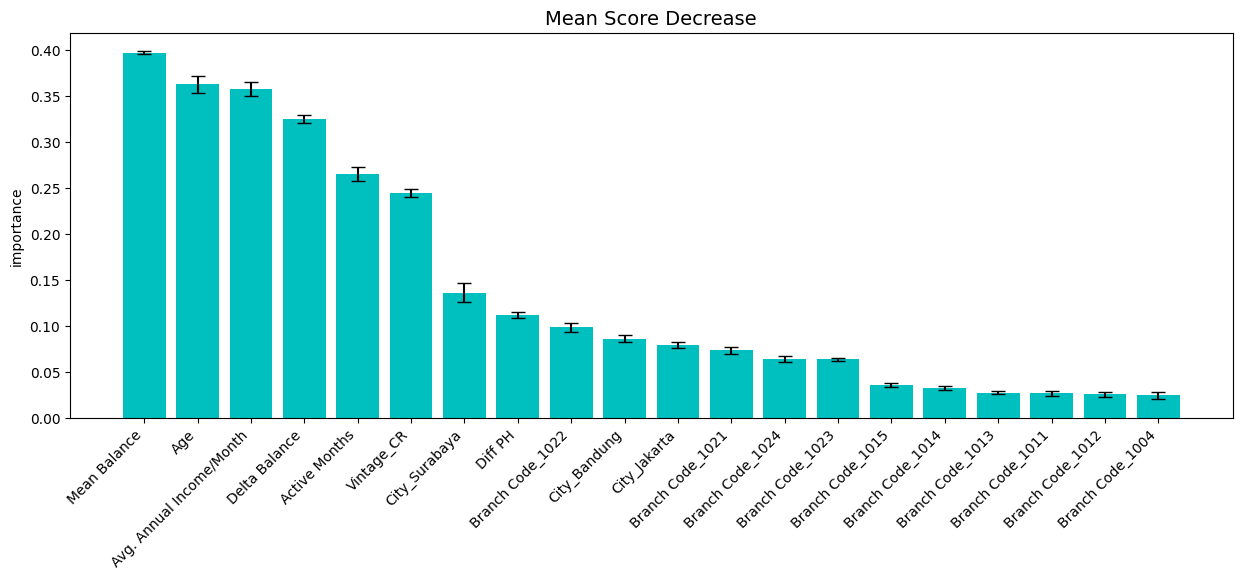

In [103]:
df_imp6 = mean_score_decrease(X2_train, y2_train, RF_Grid2, plot=True, topk=20)

#**Summary**


Among all the models, the average accuracy is above 60%, but the recall score is below 40%. This means that many customers who are actually at risk of defaulting are predicted not to default. Therefore, it can be concluded that in this iteration of model development, the desired objective has not yet been achieved.